In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.structures import pairwise_iou, boxes
from detectron2.structures import BoxMode


import torch
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Checking visually

Define the pre-trained DBT prediction model

In [3]:
config_file = str(repo_path / 'data/models/config_trained_R_101_30k.yaml')
model_file = str(repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth')
min_score = 1e-1 # minimum score to keep prediction

# load trained network 
cfg = get_cfg()
cfg.merge_from_file(config_file)
#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = model_file
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score #0.8  # set the testing threshold for this model
# define predictor
predictor = DefaultPredictor(cfg)

Load training test

In [4]:
# settings
im_dir = repo_path / 'data/CDD-CESM/images/substracted'
test_dataframe = pd.read_csv(repo_path / 'data/CDD-CESM/metadata/bboxes/split_1/test_set.csv')
# print info
print(f'Number of patients: {len(test_dataframe["patient_id"].unique())}')
print(f'Number of lesions: {len(test_dataframe)}')
print(f'Number of images: {len(test_dataframe["image_name"].unique())}')

Number of patients: 32
Number of lesions: 140
Number of images: 56


/home/ricardo/miniconda3/envs/detectron-new/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


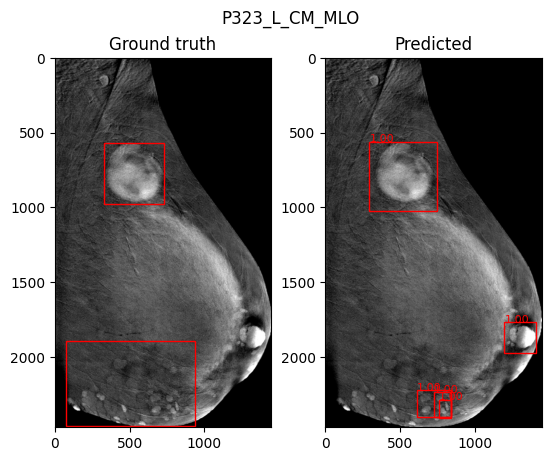

In [5]:
for im_name in test_dataframe['image_name'].unique()[-1:]:
    im_bboxes = test_dataframe[test_dataframe['image_name']==im_name] # filter bboxes for this image
    bboxes_info = [eval(bbox) for bbox in im_bboxes['bbox']] # get all regions bboxes
    gt_bboxes = [[bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] for bbox in bboxes_info]

    # read image
    im_path = im_dir / f'{im_name}.jpg'
    im_array = cv.imread(str(im_path))

    # prediction
    outputs = predictor(im_array)
    out = outputs["instances"].to("cpu")
    

    # show all bounding boxes on the image
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(im_array)
    ax[0].set_title('Ground truth')
    for bbox in gt_bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]), width = bbox[2]-bbox[0], height = bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
    ax[1].imshow(im_array)
    ax[1].set_title('Predicted')
    for bbox in out.pred_boxes:
        rect = patches.Rectangle((bbox[0],bbox[1]), width = bbox[2]-bbox[0], height = bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)
        # add score
        ax[1].text(bbox[0],bbox[1],f'{out.scores[0]:.2f}',color='r',fontsize=8)
    # set figure tilte
    fig.suptitle(im_name)
    plt.show()

# Checking using detectron API

Building dataset for evaluation

In [6]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import random

In [7]:
# settings
im_dir = repo_path / 'data/CDD-CESM/images/substracted'
test_dataframe = pd.read_csv(repo_path / 'data/CDD-CESM/metadata/bboxes/split_1/test_set.csv')
# print info
print(f'Number of patients: {len(test_dataframe["patient_id"].unique())}')
print(f'Number of lesions: {len(test_dataframe)}')
print(f'Number of images: {len(test_dataframe["image_name"].unique())}')

Number of patients: 32
Number of lesions: 140
Number of images: 56


In [8]:
def get_dicts(dataframe):
    dataset_dicts = []
    df = dataframe.copy()

    df['image_id'] = df['image_name'].astype('category').cat.codes


    for _, row in df.iterrows():
        
        record = {}
        
        filename = im_dir / (row["image_name"] + ".jpg")
        height, width = cv.imread(str(filename)).shape[:2]
        
        record["file_name"] = str(filename)
        record["image_id"] = row["image_id"]
        record["height"] = height
        record["width"] = width
        

        bbox_roi = eval(row["bbox"])   
        px = [bbox_roi[0], bbox_roi[0]+bbox_roi[2], bbox_roi[0]+bbox_roi[2], bbox_roi[0]]
        py = [bbox_roi[1], bbox_roi[1], bbox_roi[1]+bbox_roi[3], bbox_roi[1]+bbox_roi[3]]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]
        objs = []
        obj =  {
                "bbox": [bbox_roi[0] , bbox_roi[1], bbox_roi[0]+bbox_roi[2], bbox_roi[1]+bbox_roi[3]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

DatasetCatalog.register("CEM_test", lambda: get_dicts(test_dataframe))
MetadataCatalog.get("CEM_test").set(thing_classes=["mass"])
CEM_metadata = MetadataCatalog.get("CEM_test")

In [17]:
config_file = str(repo_path / 'data/models/config_trained_R_101_30k.yaml')
model_file = str(repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth')
min_score = 0.01 # minimum score to keep prediction

# load trained network 
cfg = get_cfg()
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_file
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score #0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("CEM_test", )

dataset_dicts = get_dicts(test_dataframe)
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator(dataset_name="CEM_test", distributed=False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "CEM_test")

In [18]:
inference_on_dataset(predictor.model, val_loader, evaluator)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:

OrderedDict([('bbox',
              {'AP': 5.312036325085113,
               'AP50': 10.901678678087196,
               'AP75': 5.217903963280227,
               'APs': nan,
               'APm': 0.0,
               'APl': 5.493815140657297})])